In [18]:
# app.py
import tensorflow as tf
from flask import Flask, request, jsonify
import cv2
import numpy as np
from PIL import Image
import io
from google.colab.patches import cv2_imshow




def make_edges_white(image, w,center):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    offset_height = (image.shape[1] / 2) - center[1]
    offset_width = (image.shape[0]/2) - center[0]
    #offset_width = image.shape[1] / 2

    # Create a binary mask where the edges will be white
    mask = np.zeros_like(gray)

    # Define the edge width in pixels
    edge_width = w
    print(str(edge_width) + " " + str(edge_width-offset_height))
    # Set the edge region of the mask to white
    mask[0:int(edge_width-(2*offset_width)), :] = 255 #try swittching them?
    mask[int(-edge_width+offset_width):, :] = 255
    mask[:, 0:int(edge_width-offset_height)] = 255
    mask[:, int(-edge_width+offset_height):] = 255

    # Combine the mask with the grayscale image
    # The mask will be applied to the grayscale image to make the edges white
    result = gray.copy()
    result[mask == 255] = 255
    #cv2_imshow(result)
    return result


def img(image):

    # image_file = "/My photo - Date (1).jpg"
    # image = Image.open(image_file).convert('RGB')
    # image = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Edge detection
    thres, gray = cv2.threshold(gray, 25, 255,cv2.THRESH_BINARY)
    cv2_imshow(gray)
    edges = cv2.Canny(gray, 25, 100, apertureSize=3)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest square contour is the Tic-Tac-Toe board
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    board_contour = None
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    #cv2.imwrite('contour_image.jpg', image)  # Save contour image
    # cv2_imshow(image)
    thres, image = cv2.threshold(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY), 25, 255,cv2.THRESH_BINARY)
    # cv2_imshow(image)

    for contour in contours:
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            board_contour = approx
            break

    if board_contour is None:
        return 'No Tic-Tac-Toe board found', 400
    board_contour_img = image.copy()
    cv2.drawContours(board_contour_img, contours, -1, (0, 255, 0), 2)
    #cv2.imwrite('board_contour_image.jpg', board_contour_img)  # Save contour image
    cv2_imshow( board_contour_img)
    # Warp perspective to get a top-down view of the board
    pts = np.float32([point[0] for point in board_contour])
    side = max(np.linalg.norm(pts[0] - pts[1]), np.linalg.norm(pts[1] - pts[2]),
               np.linalg.norm(pts[2] - pts[3]), np.linalg.norm(pts[3] - pts[0]))

    dst = np.float32([[0, side - 1],[0, 0], [side - 1, 0],[side - 1, side - 1] ])

    matrix = cv2.getPerspectiveTransform(pts, dst)
    board = cv2.warpPerspective(gray, matrix, (int(side), int(side)))
    board = cv2.flip(board, 1)

    cv2_imshow( board)  # Save warped board image

    # Divide the board into 9 cells
    step = board.shape[0] // 3
    cells = []
    for i in range(3):
        for j in range(3):
            cell = board[i * step:(i + 1) * step, j * step:(j + 1) * step]




            cells.append(cell)

    # Placeholder for recognizing Xs and Os
    board_state = []
    # for cell in cells:
    #     edgess = cv2.Canny(cell, 50, 150, apertureSize=3)

    #     contours, _ = cv2.findContours(edgess, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #cell = cv2.drawContours(cell, contours, -1, (0, 255, 0), 2)
    # edgess = cv2.Canny(cells[0], 50,150, apertureSize=3)
    # contours, _ = cv2.findContours(edgess, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cells[0] = cv2.drawContours(cells[0], contours, -1, (0, 255, 0), 2)
    num = 5
    for cell in cells:
      center = [cell.shape[0]/2,cell.shape[1]/2]


      cell = make_edges_white(cell,20, center)

      threshold, black_pixels = cv2.threshold(cell, 100, 255,cv2.THRESH_BINARY)


      edges = cv2.Canny(black_pixels, 60, 150, apertureSize=3)
      contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      if len(contours) > 0:
          x, y, w, h = cv2.boundingRect(contours[len(contours)-1])
          # cv2.drawContours(black_pixels, contours, -1, (0, 255, 0), 2)
          print(str(x) + str(y) + str(w) + str(h))
          #cv2.rectangle(black_pixels, (x, y), (x + w, y + h), (0, 255, 0), 2)
          print(center)
          center = [x+w/2,y+h/2]
          print(center)
          rgb = cv2.cvtColor(black_pixels, cv2.COLOR_GRAY2BGR)
          pil_compatible = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

          pil_image = Image.fromarray(pil_compatible)
          pil_image.show()
          result = ai(pil_image )
          print(result+ "result")
          if("Circle" in result):
            board_state.append("O")
          elif( "X" in result):
            board_state.append("X")
          else:
            board_state.append("blank")

          cv2.drawContours(cell, contours, -1, (255, 255, 255), 2)
          #cv2.circle(black_pixels, (int(center[0]), int(center[1])), 10, (0, 0, 255), -1)
          cv2_imshow(cell)
      cv2_imshow(black_pixels)



      pixel_count = cv2.countNonZero(black_pixels)
      black_pixels = make_edges_white(black_pixels,40,center)
      pixel_count_2 = cv2.countNonZero(black_pixels)



      if(pixel_count >= cell.size * 0.999999999):
        board_state.append("empty")


      # print(str(black_pixels) + " " +  str(cells[0].size))
      # image = cv2.resize(black_pixels, (224, 224), interpolation=cv2.INTER_AREA)
      # image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)
      # image = (image / 127.5) - 1
      # prediction = model.predict(image)
      # index = np.argmax(prediction)
      # class_name = class_names[index]
      # confidence_score = prediction[0][index]

      # # Print prediction and confidence score
      # print("Class:", class_name[2:], end="")
      # print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")





    # Respond with the board state

    # return board_state
    _, buffer = cv2.imencode('.png', board)  # Use '.jpg' for JPEG

    #Step 3: Convert the buffer to a base64 string
    base64_string = base64.b64encode(buffer).decode('utf-8')
    data_uri = f"data:image/png;base64,{base64_string}"

    return [board_state, data_uri]
# img()




In [7]:
!pip install flask_cors

https://0214-34-173-112-219.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:4000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:40] "OPTIONS / HTTP/1.1" 200 -
<ipython-input-3-e3cc088acb46>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)


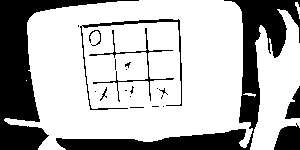

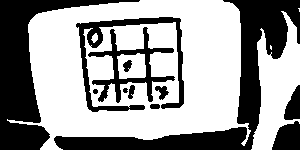

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:40] "POST / HTTP/1.1" 200 -


20 20.0
error: 'NoneType' object has no attribute 'clip'


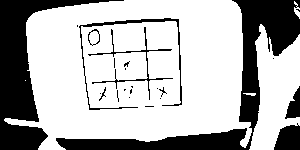

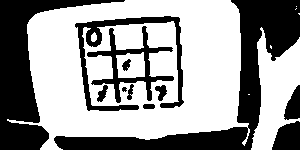

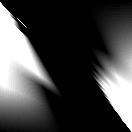

20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 48ms/step
Class: 0 Circle, Confidence Score: 0.9993103742599487
0 Circleresult


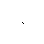

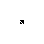

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 44ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


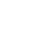

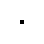

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 62ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


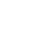

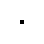

40 39.5
20 20.0


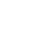

40 40.0
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 58ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


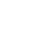

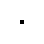

40 39.5
20 20.0


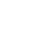

40 40.0
20 20.0
192054
[22.0, 22.0]
[21.5, 22.0]
1/1 [==============================] - 0s 48ms/step
Class: 0 Circle, Confidence Score: 0.9995342493057251
0 Circleresult


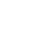

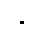

40 40.0
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 40ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


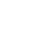

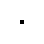

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 45ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


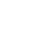

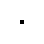

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:42] "POST / HTTP/1.1" 200 -


40 39.5
[['O', 'O', 'O', 'empty', 'O', 'empty', 'O', 'O', 'O'], '']

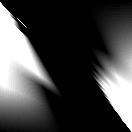

<ipython-input-3-e3cc088acb46>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)


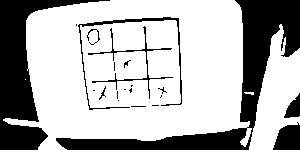

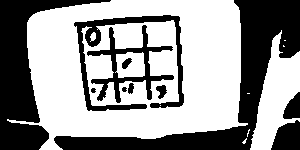

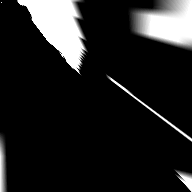

20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 50ms/step
Class: 0 Circle, Confidence Score: 0.9980983138084412
0 Circleresult


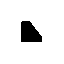

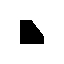

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 46ms/step
Class: 0 Circle, Confidence Score: 0.9950494170188904
0 Circleresult


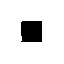

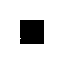

40 39.5
20 20.0
1937248
[32.0, 32.0]
[31.0, 41.0]
1/1 [==============================] - 0s 69ms/step
Class: 0 Circle, Confidence Score: 0.5763409733772278
0 Circleresult


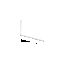

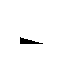

40 49.0
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 68ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


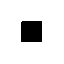

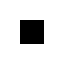

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 86ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


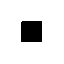

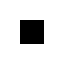

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 89ms/step
Class: 0 Circle, Confidence Score: 0.9959151148796082
0 Circleresult


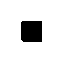

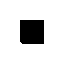

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 75ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


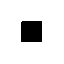

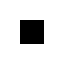

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 61ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


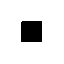

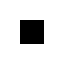

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 89ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


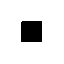

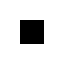

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:44] "POST / HTTP/1.1" 200 -


40 39.5
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], '']

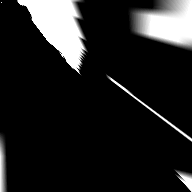

<ipython-input-3-e3cc088acb46>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)


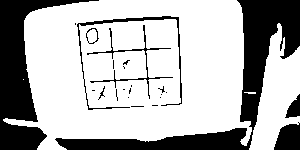

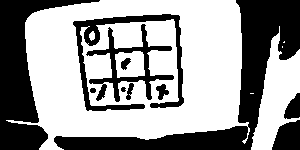

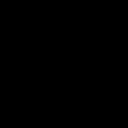

20 20.0


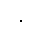

40 40.0
20 20.0


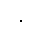

40 40.0
20 20.0


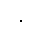

40 40.0
20 20.0


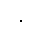

40 40.0
20 20.0


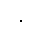

40 40.0
20 20.0


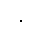

40 40.0
20 20.0


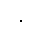

40 40.0
20 20.0


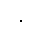

40 40.0
20 20.0


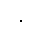

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:45] "POST / HTTP/1.1" 200 -


40 40.0
[[], '']

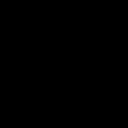

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:45] "OPTIONS / HTTP/1.1" 200 -


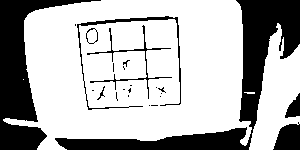

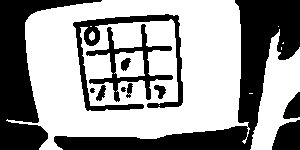

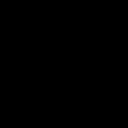

20 20.0


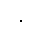

40 40.0
20 20.0


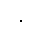

40 40.0
20 20.0


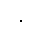

40 40.0
20 20.0


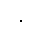

40 40.0
20 20.0


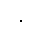

40 40.0
20 20.0


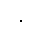

40 40.0
20 20.0


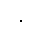

40 40.0
20 20.0


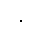

40 40.0
20 20.0


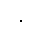

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:45] "POST / HTTP/1.1" 200 -


40 40.0
[[], '']

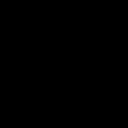

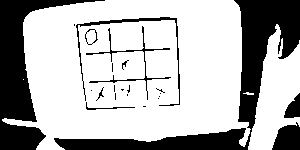

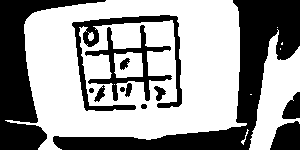

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:46] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']


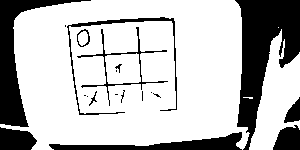

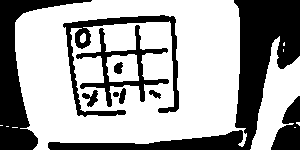

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:47] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']


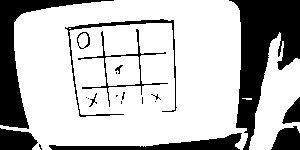

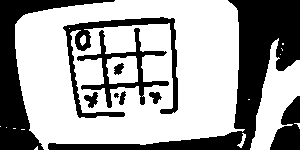

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:48] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']


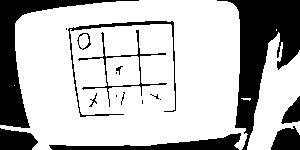

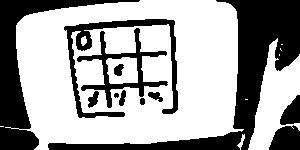

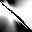

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:49] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']

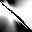

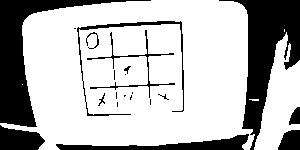

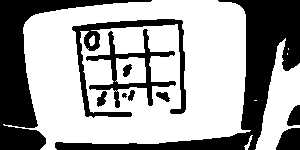

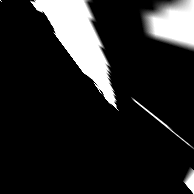

20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 54ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


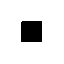

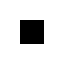

40 39.5
20 20.0
27191725
[32.0, 32.0]
[35.5, 31.5]
1/1 [==============================] - 0s 41ms/step
Class: 0 Circle, Confidence Score: 0.9941527247428894
0 Circleresult


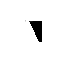

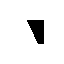

40 39.5
20 20.0
19332511
[32.0, 32.0]
[31.5, 38.5]
1/1 [==============================] - 0s 54ms/step
Class: 1 X, Confidence Score: 0.7336949706077576
1 Xresult


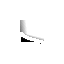

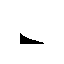

40 46.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 53ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


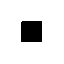

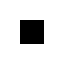

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 49ms/step
Class: 0 Circle, Confidence Score: 0.9953727126121521
0 Circleresult


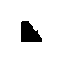

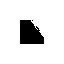

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 48ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


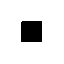

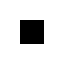

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 44ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


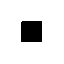

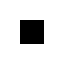

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 47ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


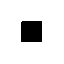

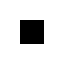

40 39.5
20 20.0
19192525
[32.0, 32.0]
[31.5, 31.5]
1/1 [==============================] - 0s 58ms/step
Class: 0 Circle, Confidence Score: 0.9933345317840576
0 Circleresult


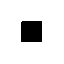

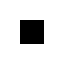

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:51] "POST / HTTP/1.1" 200 -


40 39.5
[['O', 'O', 'X', 'O', 'O', 'O', 'O', 'O', 'O'], '']

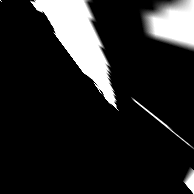

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:51] "OPTIONS / HTTP/1.1" 200 -
<ipython-input-3-e3cc088acb46>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)


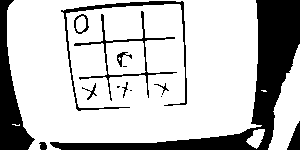

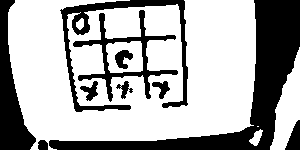

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:52] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAAAAABXZoBIAAAAM0lEQVQoFX3BAQEAAABAIP6f9kDJkCFDhgwZMmTIkCFDhgwZMmTIkCFDhgwZMmTIkCFDRjEqAB1OvoS2AAAAAElFTkSuQmCC']


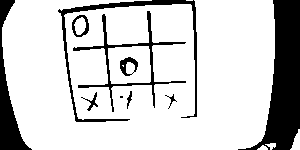

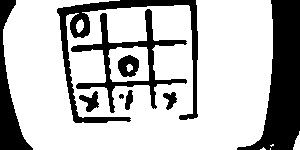

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:52] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAA4AAAAOCAAAAAA6I3INAAAAU0lEQVQIHU3BsRFEAABE0f2B5BJigeQy2lKEXmRq0YIZXdxcwoxkBQb7Hv6XuqzNB6zXNmElrLBhJayElbASR6GAlVhaBcZegaH/6vGjmjvd9voEcxMUkJbFMZEAAAAASUVORK5CYII=']


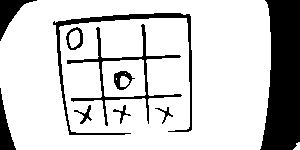

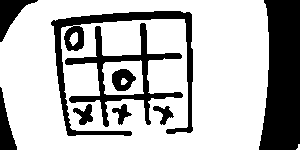

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:53] "POST / HTTP/1.1" 200 -


20 20.0
error: 'NoneType' object has no attribute 'clip'


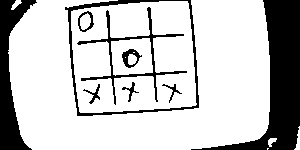

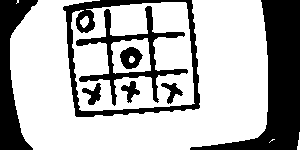

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:54] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']


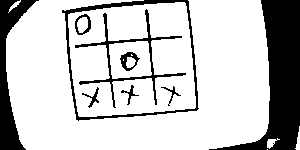

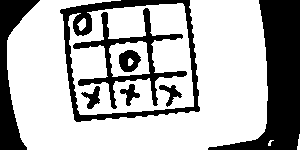

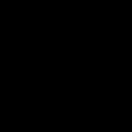

20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 48ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


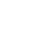

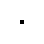

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 48ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


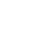

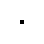

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 52ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


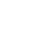

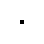

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 53ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


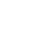

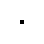

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 42ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


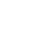

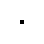

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 40ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


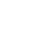

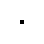

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 40ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


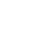

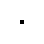

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 41ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


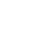

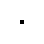

40 39.5
20 20.0
191955
[22.0, 22.0]
[21.5, 21.5]
1/1 [==============================] - 0s 53ms/step
Class: 0 Circle, Confidence Score: 0.9995561242103577
0 Circleresult


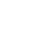

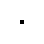

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:56] "POST / HTTP/1.1" 200 -


40 39.5
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], '']

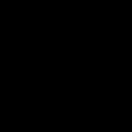

<ipython-input-3-e3cc088acb46>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)


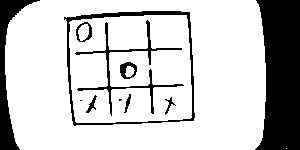

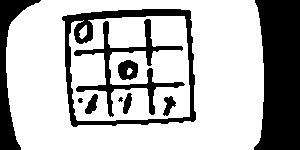

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:57] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAkAAAAJCAAAAADF+lnMAAAAL0lEQVQIHS3BQRHAIAADwTsbuKliLNQMj6oIA82u4aehDGUoQxnKUK7B8U3D9T4bzdsLm/iUuD4AAAAASUVORK5CYII=']


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:57] "OPTIONS / HTTP/1.1" 200 -


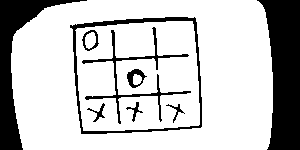

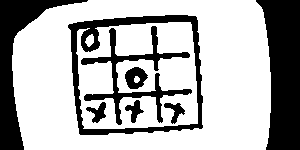

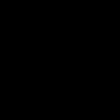

20 20.0


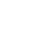

40 40.0
20 20.0


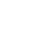

40 40.0
20 20.0


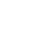

40 40.0
20 20.0


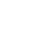

40 40.0
20 20.0


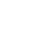

40 40.0
20 20.0


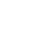

40 40.0
20 20.0


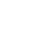

40 40.0
20 20.0


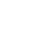

40 40.0
20 20.0


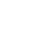

INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:57] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']

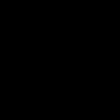

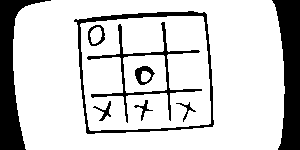

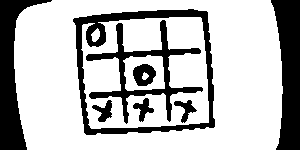

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:58] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAkAAAAJCAAAAADF+lnMAAAANUlEQVQIHS3BQRGAMBAEwRlVeSMBd3lGCk/koIBN1eW6DeW5/KXchmMajs/QDM3QDM13UNYGdnkMe1CWVpkAAAAASUVORK5CYII=']


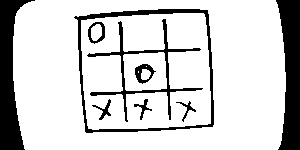

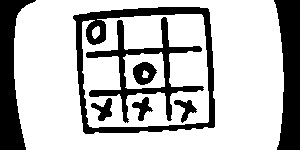

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:09:59] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']


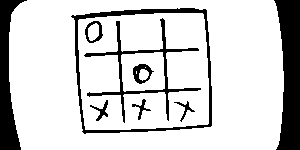

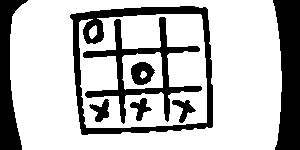

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:00] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAAAAACoWZBhAAAAWklEQVQIHWOcnsHAUDiBISvUkfE/AxAsSGSIUGD8zwACD/Q/MTD+ZwCBz2ovGBj/M4DBj8QVjP8ZIGCfM+N/BihgZPzPAAErIhn/M0CA5g3Gp1IMQPBrUSoDAJ3/GIP9DfUOAAAAAElFTkSuQmCC']


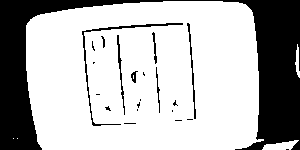

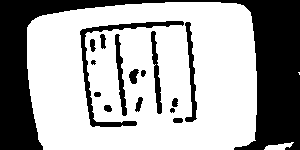

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:01] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAQAAAAECAAAAACMmsGiAAAAHElEQVQIHWP8z8jAwBi+kiGEsX2SOAMjw38GBgAxJQSIba+yBgAAAABJRU5ErkJggg==']


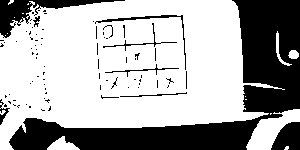

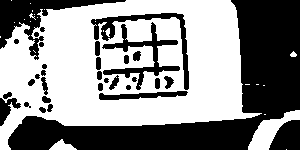

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:02] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAkAAAAJCAAAAADF+lnMAAAAQElEQVQIHWN02c0ABoyMt1UYwOAe4x9mBjDYyfifAQJOMP5ngALG/wxQwPifAQIOMF7VYgCDaYxeUxUYgOC3NgBhww3dp64I0gAAAABJRU5ErkJggg==']


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:03] "OPTIONS / HTTP/1.1" 200 -


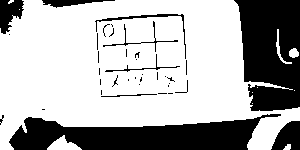

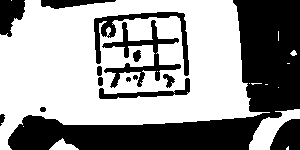

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:03] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAkAAAAJCAAAAADF+lnMAAAAQElEQVQIHS3BQRlAQACE0X9uCmw8HbRQw+5NAxE2ggycKDA+xnua5gHY1kVt5NWrjsJnl4lTJm6ZuGR+MtFkoj9v0BF7M9ntNQAAAABJRU5ErkJggg==']


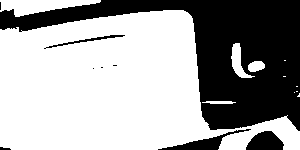

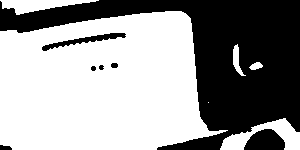

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:04] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAAsAAAALCAAAAACMxyj6AAAAQUlEQVQIHT3BsQ1AUBhG0XsrMZJOdIawl9oCRhCbmEL7SeS9/xzni989TIZuNXS7oXsMxVAMxVAMxXekOd0OmuUDM5UOtPPq7PgAAAAASUVORK5CYII=']


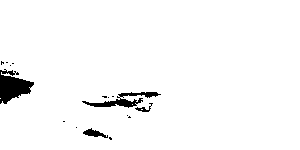

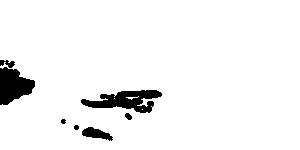

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:05] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABIAAAASCAAAAABzpdGLAAAALUlEQVQYGV3BsQEAAACCIP3/aNsD4xnPeMYznvGMZzzjGc94xjOe8YxnPOMZb6EcEgEWkwzLAAAAAElFTkSuQmCC']


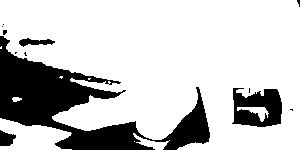

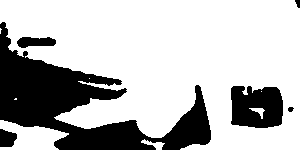

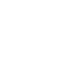

20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


40 40.0
20 20.0


INFO:werkzeug:127.0.0.1 - - [24/Aug/2024 07:10:06] "POST / HTTP/1.1" 200 -


40 40.0
[['empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty'], '']

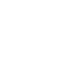

In [ ]:
import os
import threading
import getpass
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
from flask_cors import CORS

conf.get_default().auth_token = "2kuJ2SpmZEZyRLbmwj8eCHrqeG2_n3z6FFgyHWMx2Eufe4Lf"

app = Flask(__name__)
CORS(app)
port = "4000"

# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url

# Update any base URLs to use the public ngrok URL
app.config["BASE_URL"] = public_url
print(public_url)

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/", methods=["POST"])
def index():
    data = request.json
    base64_string = data.get("base64")

    if not base64_string:
        return jsonify({"error": "No base64 image data provided"}), 400

    try:
        image = readb64(base64_string)
    except Exception as e:
        return jsonify({"error": f"Image could not be read: {str(e)}"}), 400

    try:
        result = img(image)
    except Exception as e:
        result = f"error: {str(e)}"

    print(result)
    return jsonify({"result": result})

# Start the Flask server in a new thread
threading.Thread(target=app.run(port = port), kwargs={"use_reloader": False}).start()


In [3]:
import base64

def readb64(uri):
  encoded_data = uri.split(',')[1]
  nparr = np.fromstring(base64.b64decode(encoded_data),np.uint8)
  img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
  return img


In [4]:
!pip install pyngrok
!ngrok authtoken '2kuJ2SpmZEZyRLbmwj8eCHrqeG2_n3z6FFgyHWMx2Eufe4Lf'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
#teachable machine code

In [2]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("keras_model.h5", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
def ai(image):


  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

  # turn the image into a numpy array
  image_array = np.asarray(image)

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

  # Load the image into the array
  data[0] = normalized_image_array

  #Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index].strip()
  confidence_score = prediction[0][index]
  print(f"Class: {class_name}, Confidence Score: {confidence_score}")
  return class_name

# Print prediction and confidence score
# print("Class:", class_name[2:], end="")
# print("Confidence Score:", confidence_score)


In [1]:
!pip install tensorflow==2.12.0